In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("hotel_reviews.csv")
df.head()

# drop NaN values for lat and long
df = df.dropna()
df.shape

(512470, 17)

In [3]:
#df.shape

In [3]:
# append the positive and negative text reviews
df["combine_review"] = df["Negative_Review"] + df["Positive_Review"]

df["bad_review"] = df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)

df = df[["combine_review", "bad_review"]]
df.head()

,combine_review,bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


In [4]:
print(len(df[df["bad_review"] == 1])) # num of bad reviews
print(len(df[df["bad_review"] == 0])) # num of good reviews

22144
490326


In [6]:
#df = df.sample(frac = 0.1, replace = False, random_state=42)

In [5]:
# remove "no negative" + "no positive" from combined review
df["combine_review"] = df["combine_review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [6]:
df["combine_review"]

0          I am so angry that i made this post available...
1          No real complaints the hotel was great great ...
2          Rooms are nice but for elderly a bit difficul...
3          My room was dirty and I was afraid to walk ba...
4          You When I booked with your company on line y...
                                ...                        
515733     no trolly or staff to help you take the lugga...
515734     The hotel looks like 3 but surely not 4  Brea...
515735     The ac was useless It was a hot week in vienn...
515736     The rooms are enormous and really comfortable...
515737     I was in 3rd floor It didn t work Free Wife  ...
Name: combine_review, Length: 512470, dtype: object

In [9]:
from nltk.corpus import wordnet
import re
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [10]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["review_clean"] = df["combine_review"].apply(lambda x: clean_text(x))

In [11]:
df

,combine_review,bad_review,review_clean
0,I am so angry that i made this post available...,1,angry make post available via possible site us...
1,No real complaints the hotel was great great ...,0,real complaint hotel great great location surr...
2,Rooms are nice but for elderly a bit difficul...,0,room nice elderly bit difficult room two story...
3,My room was dirty and I was afraid to walk ba...,1,room dirty afraid walk barefoot floor look cle...
4,You When I booked with your company on line y...,0,book company line show picture room think get ...
...,...,...,...
515733,no trolly or staff to help you take the lugga...,0,trolly staff help take luggage room location
515734,The hotel looks like 3 but surely not 4 Brea...,0,hotel look like surely breakfast ok get earlie...
515735,The ac was useless It was a hot week in vienn...,1,ac useless hot week vienna give hot air
515736,The rooms are enormous and really comfortable...,0,room enormous really comfortable believe famil...


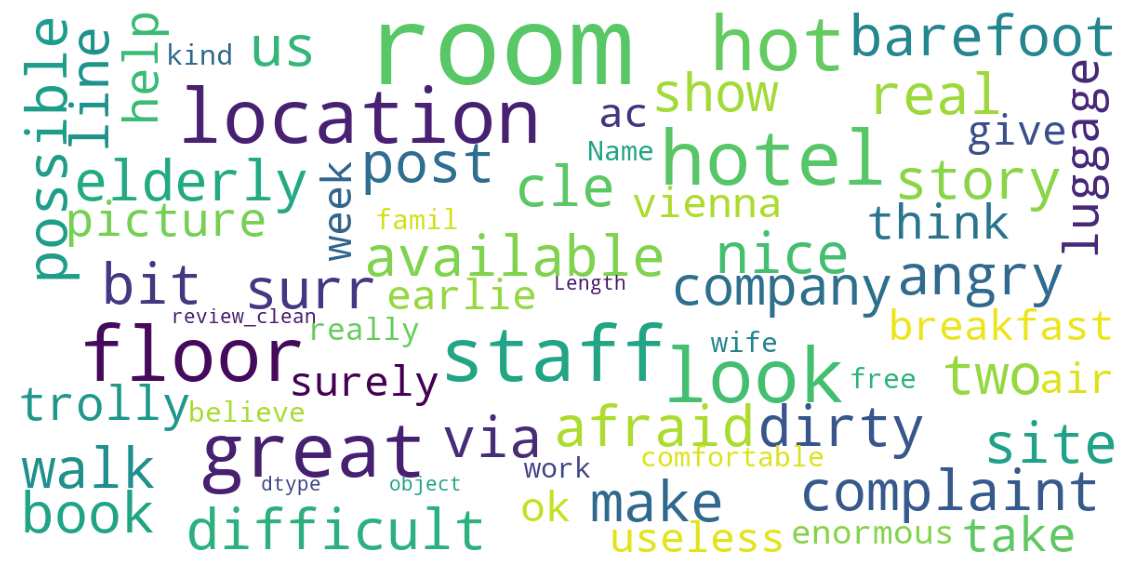

In [12]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    #fig.savefig("wordcloud.png")
    plt.show()
    
# print wordcloud

show_wordcloud(df["review_clean"])

# Topic Modeling Example

In [13]:
def make_topics(docs, preprocessor, vectorizer, topic_modeler, print_n_words=15):
    """A very simple pipeline."""
    
    # Apply preprocessor, vectorizer, and topic modeler.
    if preprocessor is not None:
        docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors


In [14]:
# Let's import them:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [15]:
docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words="english")  # Single change to add in common English stop words.
topic_modeler = NMF(10, random_state=10)

make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 ROOM, SIZE, VIEW, SERVICE, BATHROOM, SHOWER, COFFEE, AIR, NOISY, NIGHT, SPACIOUS, DIDN, HOT, TEA, FLOOR 

Topic 1:
 LOCATION, PERFECT, STAFF, CENTRAL, PRICE, CLEANLINESS, CONVENIENT, FANTASTIC, COMFORT, EXPENSIVE, QUIET, IDEAL, WIFI, SUPERB, OLD 

Topic 2:
 STAFF, FRIENDLY, HELPFUL, CLEAN, EXTREMELY, LOVELY, RECEPTION, POLITE, REALLY, WELCOMING, PROFESSIONAL, AMAZING, FANTASTIC, EFFICIENT, SUPER 

Topic 3:
 GREAT, SERVICE, VALUE, STAFF, MONEY, LOVELY, STAY, FACILITIES, BAR, ROOMS, PLACE, FOOD, VIEW, VIEWS, POOL 

Topic 4:
 GOOD, VALUE, MONEY, SERVICE, CLEAN, FOOD, FACILITIES, WIFI, RESTAURANT, REALLY, QUALITY, CLOSE, NEAR, STATION, SIZE 

Topic 5:
 EXCELLENT, SERVICE, STAFF, FACILITIES, FOOD, VALUE, CUSTOMER, RESTAURANT, STAY, MONEY, BAR, COMFORTABLE, ROOMS, SUPERB, ATTENTIVE 

Topic 6:
 HOTEL, NICE, STAY, PERFECT, CLEAN, STATION, CLOSE, REALLY, LOVELY, AMAZING, CITY, JUST, WALK, METRO, LIKE 

Topic 7:
 BED, COMFORTABLE, COMFY, CLEAN, BEDS, BATHROOM, SHOWER, PILLOWS, QUIET, R

In [34]:
# Five topics.

docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words="english")
topic_modeler = NMF(5, random_state=10)  # NOTE: I use a random state here to make the results deterministic.

make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 ROOM, SMALL, BED, HOTEL, COMFORTABLE, CLEAN, NICE, BATHROOM, ROOMS, COMFY, REALLY, SHOWER, LOVELY, VIEW, SIZE 

Topic 1:
 LOCATION, EXCELLENT, PERFECT, STAFF, ROOMS, CENTRAL, PRICE, CLEANLINESS, COMFORT, CONVENIENT, FACILITIES, FANTASTIC, SMALL, SIZE, OLD 

Topic 2:
 STAFF, FRIENDLY, HELPFUL, EXCELLENT, CLEAN, HOTEL, LOVELY, EXTREMELY, REALLY, RECEPTION, AMAZING, STAY, COMFORTABLE, ROOMS, POLITE 

Topic 3:
 GREAT, HOTEL, BREAKFAST, SERVICE, STAY, LOVELY, VALUE, STAFF, ROOMS, BAR, MONEY, PLACE, FANTASTIC, AMAZING, FOOD 

Topic 4:
 GOOD, BREAKFAST, NICE, VALUE, SERVICE, EXPENSIVE, EXCELLENT, FOOD, PRICE, MONEY, CHOICE, POOR, INCLUDED, WIFI, HOTEL 



In [34]:
# ten topics.
docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words="english")
topic_modeler = NMF(10, random_state=10)  # NOTE: I use a random state here to make the results deterministic.

make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 ROOM, SIZE, VIEW, SERVICE, BATHROOM, SHOWER, COFFEE, AIR, NOISY, NIGHT, SPACIOUS, DIDN, HOT, TEA, FLOOR 

Topic 1:
 LOCATION, PERFECT, STAFF, CENTRAL, PRICE, CLEANLINESS, CONVENIENT, FANTASTIC, COMFORT, EXPENSIVE, QUIET, IDEAL, WIFI, SUPERB, OLD 

Topic 2:
 STAFF, FRIENDLY, HELPFUL, CLEAN, EXTREMELY, LOVELY, RECEPTION, POLITE, REALLY, WELCOMING, PROFESSIONAL, AMAZING, FANTASTIC, EFFICIENT, SUPER 

Topic 3:
 GREAT, SERVICE, VALUE, STAFF, MONEY, LOVELY, STAY, FACILITIES, BAR, ROOMS, PLACE, FOOD, VIEW, VIEWS, POOL 

Topic 4:
 GOOD, VALUE, MONEY, SERVICE, CLEAN, FOOD, FACILITIES, WIFI, RESTAURANT, REALLY, QUALITY, CLOSE, NEAR, STATION, SIZE 

Topic 5:
 EXCELLENT, SERVICE, STAFF, FACILITIES, FOOD, VALUE, CUSTOMER, RESTAURANT, STAY, MONEY, BAR, COMFORTABLE, ROOMS, SUPERB, ATTENTIVE 

Topic 6:
 HOTEL, NICE, STAY, PERFECT, CLEAN, STATION, CLOSE, REALLY, LOVELY, AMAZING, CITY, JUST, WALK, METRO, LIKE 

Topic 7:
 BED, COMFORTABLE, COMFY, CLEAN, BEDS, BATHROOM, SHOWER, PILLOWS, QUIET, R

In [32]:
# Fifteen topics.

docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words="english")
topic_modeler = NMF(15, random_state=10, max_iter=1000)  # NOTE: I use a random state here to make the results deterministic.

make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 ROOM, SIZE, VIEW, BATHROOM, COFFEE, SHOWER, AIR, NOISY, NIGHT, HOT, SPACIOUS, DIDN, TEA, FLOOR, WATER 

Topic 1:
 LOCATION, STAFF, CENTRAL, PRICE, CLEANLINESS, FANTASTIC, CONVENIENT, COMFORT, EXPENSIVE, IDEAL, QUIET, WIFI, SUPERB, OLD, NEAR 

Topic 2:
 FRIENDLY, STAFF, EFFICIENT, PROFESSIONAL, SUPER, WELCOMING, ATTENTIVE, LOVELY, ACCOMMODATING, HELPFULL, RECEPTION, HELP, BAR, ATMOSPHERE, WELCOME 

Topic 3:
 GREAT, VALUE, STAFF, MONEY, STAY, LOVELY, FACILITIES, ROOMS, PLACE, VIEW, BAR, VIEWS, POOL, FOOD, WONDERFUL 

Topic 4:
 GOOD, VALUE, MONEY, FOOD, FACILITIES, WIFI, REALLY, RESTAURANT, CLOSE, NEAR, STATION, SIZE, QUALITY, SHOWER, PRICE 

Topic 5:
 EXCELLENT, STAFF, FACILITIES, VALUE, FOOD, MONEY, COMFORTABLE, STAY, ROOMS, RESTAURANT, CHOICE, ATTENTIVE, SUPERB, DEFINITELY, ROUND 

Topic 6:
 HOTEL, STAY, STATION, LOVELY, CLOSE, LIKE, AMAZING, WALK, CITY, REALLY, JUST, BEAUTIFUL, METRO, LONDON, AREA 

Topic 7:
 BED, COMFORTABLE, COMFY, BEDS, SHOWER, BATHROOM, REALLY, LOVELY, P

In [30]:
# 5 topics with max_iter:2000
docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words="english")
topic_modeler = NMF(5, random_state=10, max_iter=2000)

make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 ROOM, SMALL, BED, HOTEL, COMFORTABLE, CLEAN, NICE, BATHROOM, ROOMS, COMFY, REALLY, SHOWER, LOVELY, VIEW, SIZE 

Topic 1:
 LOCATION, EXCELLENT, PERFECT, STAFF, ROOMS, CENTRAL, PRICE, CLEANLINESS, COMFORT, CONVENIENT, FACILITIES, FANTASTIC, SMALL, SIZE, OLD 

Topic 2:
 STAFF, FRIENDLY, HELPFUL, EXCELLENT, CLEAN, HOTEL, LOVELY, EXTREMELY, REALLY, RECEPTION, AMAZING, STAY, COMFORTABLE, ROOMS, POLITE 

Topic 3:
 GREAT, HOTEL, BREAKFAST, SERVICE, STAY, LOVELY, VALUE, STAFF, ROOMS, BAR, MONEY, PLACE, FANTASTIC, AMAZING, FOOD 

Topic 4:
 GOOD, BREAKFAST, NICE, VALUE, SERVICE, EXPENSIVE, EXCELLENT, FOOD, PRICE, MONEY, CHOICE, POOR, INCLUDED, WIFI, HOTEL 



In [48]:
# 15 topics with max, min 
docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words = 'english', strip_accents = 'ascii', max_df = 0.95, min_df = 0.02)
topic_modeler = NMF(15, random_state=10, max_iter=3000)  # NOTE: I use a random state here to make the results deterministic.
make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 STAFF, HELPFUL, RECEPTION, EXTREMELY, LOVELY, AMAZING, FANTASTIC, DESK, FOOD, COULDN, RESTAURANT, BEAUTIFUL, FACILITIES, WAY, LOVED 

Topic 1:
 ROOM, SIZE, VIEW, FLOOR, AIR, NOISY, COFFEE, BOOKED, SPACIOUS, WINDOW, DID, TEA, HOT, NIGHT, GOT 

Topic 2:
 LOCATION, PERFECT, GOOD, STAFF, CENTRAL, PRICE, FANTASTIC, NEAR, OLD, WIFI, FACILITIES, QUIET, SIZE, EXPENSIVE, NOISY 

Topic 3:
 HOTEL, BEAUTIFUL, RECOMMEND, BEST, STAYED, BOOKING, LIKE, OLD, AMAZING, MODERN, FANTASTIC, PRICE, PARKING, TIME, BOOKED 

Topic 4:
 BREAKFAST, GOOD, EXPENSIVE, PRICE, VALUE, FOOD, POOR, QUALITY, MONEY, WIFI, COFFEE, BETTER, PARKING, BIT, RESTAURANT 

Topic 5:
 GREAT, BREAKFAST, VALUE, LOVELY, VIEW, FACILITIES, MONEY, POOL, PLACE, BAR, FANTASTIC, FOOD, BEAUTIFUL, COMFY, RESTAURANTS 

Topic 6:
 EXCELLENT, BREAKFAST, FACILITIES, COMFORTABLE, FOOD, VALUE, STAFF, RESTAURANT, MONEY, LITTLE, QUIET, LONDON, RECOMMEND, QUALITY, RESTAURANTS 

Topic 7:
 BED, COMFORTABLE, COMFY, SHOWER, BATHROOM, BEDS, DOUBLE, L

In [50]:
# 5 topics with max, min

docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words = 'english', strip_accents = 'ascii', max_df = 0.95, min_df = 0.02)
topic_modeler = NMF(5, random_state=10, max_iter=3000)  # NOTE: I use a random state here to make the results deterministic.
make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 STAFF, FRIENDLY, HELPFUL, EXCELLENT, CLEAN, LOVELY, RECEPTION, COMFORTABLE, EXTREMELY, STAY, REALLY, ROOMS, AMAZING, BAR, GREAT 

Topic 1:
 ROOM, SMALL, BED, COMFORTABLE, BATHROOM, CLEAN, SHOWER, NICE, VIEW, SIZE, COMFY, SERVICE, NIGHT, DIDN, FLOOR 

Topic 2:
 LOCATION, GREAT, EXCELLENT, PERFECT, ROOMS, SMALL, CENTRAL, STAFF, FACILITIES, SERVICE, FANTASTIC, CLOSE, VALUE, PRICE, NEAR 

Topic 3:
 HOTEL, STAY, NICE, ROOMS, CLEAN, LIKE, REALLY, STATION, JUST, CLOSE, GREAT, LOVELY, PERFECT, WALK, TIME 

Topic 4:
 BREAKFAST, GOOD, NICE, EXCELLENT, ROOMS, EXPENSIVE, SERVICE, FOOD, CLEAN, PRICE, COMFORTABLE, VALUE, POOR, RESTAURANT, CLOSE 



In [ ]:
# Topic 0:
#  ROOM, SMALL, BED, HOTEL, COMFORTABLE, CLEAN, NICE, BATHROOM, ROOMS, COMFY, REALLY, SHOWER, LOVELY, VIEW, SIZE 

# Topic 1:
#  LOCATION, EXCELLENT, PERFECT, STAFF, ROOMS, CENTRAL, PRICE, CLEANLINESS, COMFORT, CONVENIENT, FACILITIES, FANTASTIC, SMALL, SIZE, OLD 

# Topic 2:
#  STAFF, FRIENDLY, HELPFUL, EXCELLENT, CLEAN, HOTEL, LOVELY, EXTREMELY, REALLY, RECEPTION, AMAZING, STAY, COMFORTABLE, ROOMS, POLITE 

# Topic 3:
#  GREAT, HOTEL, BREAKFAST, SERVICE, STAY, LOVELY, VALUE, STAFF, ROOMS, BAR, MONEY, PLACE, FANTASTIC, AMAZING, FOOD 

# Topic 4:
#  GOOD, BREAKFAST, NICE, VALUE, SERVICE, EXPENSIVE, EXCELLENT, FOOD, PRICE, MONEY, CHOICE, POOR, INCLUDED, WIFI, HOTEL 

In [51]:
# 6 topics with max, min

docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words = 'english', strip_accents = 'ascii', max_df = 0.95, min_df = 0.02)
topic_modeler = NMF(6, random_state=10, max_iter=3000)  # NOTE: I use a random state here to make the results deterministic.
make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 STAFF, FRIENDLY, HELPFUL, EXCELLENT, CLEAN, RECEPTION, LOVELY, EXTREMELY, COMFORTABLE, REALLY, STAY, ROOMS, AMAZING, BAR, NICE 

Topic 1:
 ROOM, SMALL, BED, COMFORTABLE, BATHROOM, CLEAN, SHOWER, NICE, VIEW, SIZE, COMFY, SERVICE, NIGHT, DIDN, FLOOR 

Topic 2:
 LOCATION, EXCELLENT, PERFECT, ROOMS, SMALL, CENTRAL, GOOD, STAFF, PRICE, NEAR, CLOSE, STATION, FACILITIES, FANTASTIC, OLD 

Topic 3:
 HOTEL, STAY, NICE, ROOMS, LIKE, CLEAN, STATION, CLOSE, JUST, REALLY, PERFECT, WALK, LOVELY, TIME, CITY 

Topic 4:
 BREAKFAST, GOOD, NICE, ROOMS, EXCELLENT, EXPENSIVE, FOOD, SERVICE, PRICE, CLEAN, VALUE, COMFORTABLE, POOR, RESTAURANT, CLOSE 

Topic 5:
 GREAT, SERVICE, BAR, LOVELY, ROOMS, STAY, BED, COMFORTABLE, VALUE, BREAKFAST, COMFY, VIEW, PLACE, FOOD, POOL 



In [52]:
# 7 topics with max, min

docs = df["combine_review"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words = 'english', strip_accents = 'ascii', max_df = 0.95, min_df = 0.02)
topic_modeler = NMF(7, random_state=10, max_iter=3000)  # NOTE: I use a random state here to make the results deterministic.
make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 STAFF, FRIENDLY, HELPFUL, CLEAN, RECEPTION, LOVELY, EXTREMELY, COMFORTABLE, REALLY, ROOMS, STAY, AMAZING, NICE, FANTASTIC, BAR 

Topic 1:
 ROOM, SMALL, BED, COMFORTABLE, BATHROOM, CLEAN, SHOWER, NICE, VIEW, SIZE, COMFY, NIGHT, DIDN, FLOOR, BIT 

Topic 2:
 LOCATION, PERFECT, ROOMS, SMALL, STAFF, GOOD, CENTRAL, PRICE, CLOSE, NEAR, STATION, FANTASTIC, OLD, WIFI, QUIET 

Topic 3:
 HOTEL, STAY, NICE, ROOMS, LIKE, CLEAN, STATION, CLOSE, JUST, REALLY, PERFECT, WALK, LOVELY, TIME, CITY 

Topic 4:
 BREAKFAST, GOOD, NICE, ROOMS, EXPENSIVE, CLEAN, PRICE, FOOD, VALUE, COMFORTABLE, POOR, CLOSE, BIT, REALLY, WIFI 

Topic 5:
 GREAT, LOVELY, BAR, SERVICE, ROOMS, STAY, BED, COMFORTABLE, BREAKFAST, VALUE, COMFY, VIEW, PLACE, FOOD, FACILITIES 

Topic 6:
 EXCELLENT, SERVICE, FOOD, BREAKFAST, FACILITIES, BAR, RESTAURANT, STAFF, COMFORTABLE, STAY, VALUE, QUALITY, LONDON, MONEY, RECOMMEND 



# NMF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
tfidf = TfidfVectorizer(max_df = .80, min_df = 2, stop_words = 'english')

In [44]:
dtm = tfidf.fit_transform(df['review_clean'])

In [47]:
# construct vector space model
from sklearn.decomposition import NMF

In [49]:
nmf = NMF(n_components=12, random_state=42)
nmf.fit(dtm)

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=12, random_state=42)

In [50]:
# Grab 15 words with highest coefficients per topic
for x, topic in enumerate(nmf.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC {x}:')
    print([tfidf.get_feature_names()[index] for index in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC 0:
['quite', 'floor', 'big', 'air', 'work', 'window', 'shower', 'noisy', 'little', 'bit', 'view', 'bathroom', 'size', 'small', 'room']


THE TOP 15 WORDS FOR TOPIC 1:
['facility', 'superb', 'quiet', 'wifi', 'ideal', 'expensive', 'comfort', 'fantastic', 'convenient', 'cleanliness', 'price', 'central', 'staff', 'perfect', 'location']


THE TOP 15 WORDS FOR TOPIC 2:
['attentive', 'pleasant', 'super', 'efficient', 'fantastic', 'professional', 'polite', 'really', 'welcome', 'reception', 'lovely', 'extremely', 'helpful', 'friendly', 'staff']


THE TOP 15 WORDS FOR TOPIC 3:
['price', 'close', 'near', 'quality', 'station', 'shower', 'really', 'size', 'restaurant', 'wifi', 'food', 'facility', 'money', 'value', 'good']


THE TOP 15 WORDS FOR TOPIC 4:
['shower', 'food', 'restaurant', 'pool', 'stay', 'room', 'bar', 'place', 'facility', 'money', 'lovely', 'staff', 'view', 'value', 'great']


THE TOP 15 WORDS FOR TOPIC 5:
['quiet', 'attentive', 'view', 'recommend', 'choice

In [51]:
topic_results = nmf.transform(dtm).round(3)
df['topic_num'] = topic_results.argmax(axis=1)

In [66]:
df

,combine_review,bad_review,review_clean,topic_num
0,I am so angry that i made this post available...,1,angry make post available via possible site us...,8
1,No real complaints the hotel was great great ...,0,real complaint hotel great great location surr...,4
2,Rooms are nice but for elderly a bit difficul...,0,room nice elderly bit difficult room two story...,10
3,My room was dirty and I was afraid to walk ba...,1,room dirty afraid walk barefoot floor look cle...,10
4,You When I booked with your company on line y...,0,book company line show picture room think get ...,0
...,...,...,...,...
515733,no trolly or staff to help you take the lugga...,0,trolly staff help take luggage room location,1
515734,The hotel looks like 3 but surely not 4 Brea...,0,hotel look like surely breakfast ok get earlie...,8
515735,The ac was useless It was a hot week in vienn...,1,ac useless hot week vienna give hot air,0
515736,The rooms are enormous and really comfortable...,0,room enormous really comfortable believe famil...,7
